### cmip6 data processing
#### 1. subsetting from global to hma region. 
#### 2. Spatial aggregation
- spatially distributed pixels aggregated into one value.
Note: The area of grid cell varies as a function of the cosine of the latitude.
#### 3. Temporal aggregation
- monthly values aggregated to yearly values.


In [39]:
import os
from glob import glob
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [21]:
def geog_agg(xda, exp, mod):
    ''' 
    da: xarray DataArray with 'lat', 'lon', and 'time' dimensions
    exp: experiment name (string)
    mod: model name (string)
    '''
    xda = xda - 273.15  ## convert to Celsius
    ## spatial aggregation
    weights = np.cos(np.deg2rad(xda.lat))
    weights.name = "weights"
    xda_weighted = xda.weighted(weights)
    xda_sa = xda_weighted.mean(['lat', 'lon'])
    ## temporal aggregation
    xda_sa_ta = xda_sa.groupby('time.year').mean()
    ## assign coordinates
    xda_sa_ta = xda_sa_ta.assign_coords(model=mod)
    xda_sa_ta = xda_sa_ta.expand_dims('model')
    xda_sa_ta = xda_sa_ta.assign_coords(experiment=exp)
    xda_sa_ta = xda_sa_ta.expand_dims('experiment')
    return xda_sa_ta

def cmip6_clip(cmip6_xds, gdf):
    """
    cmip6_xds: xarray Dataset with spatial dimensions 'lon' and 'lat'
    gdf: geopandas GeoDataFrame with the geometry to clip
    """
    cmip6_xds = cmip6_xds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
    cmip6_xds = cmip6_xds.rio.write_crs("EPSG:4326")
    spatial_vars = [var for var in cmip6_xds.data_vars 
                            if {'lon', 'lat'}.issubset(cmip6_xds[var].dims)]
    cmip6_clip_xds = cmip6_xds[spatial_vars].rio.clip(gdf.geometry, gdf.crs, drop=True)    
    return cmip6_clip_xds


In [22]:
# DATADIR = 'tmp/'
DATADIR = 'data/climate/cmip6'
path_hma_gtng = 'data/hma-extent/HMA/gtng_202307_hma_subregions.gpkg'
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']
path_cmip6_nc = glob(f'{DATADIR}/*/tas*.nc')
path_cmip6_nc[0:2]
proj = ccrs.PlateCarree()


In [ ]:
cmip6_xds = xr.open_dataset(path_cmip6_nc[0])
hma_gdf = gpd.read_file(path_hma_gtng)
hma_geo = hma_gdf.geometry.union_all()
hma_gdf = gpd.GeoDataFrame(geometry=[hma_geo], crs=hma_gdf.crs)


<GeoAxes: title={'center': 'time = 2015-01-16 00:00:00, height = 2.0 [m]'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

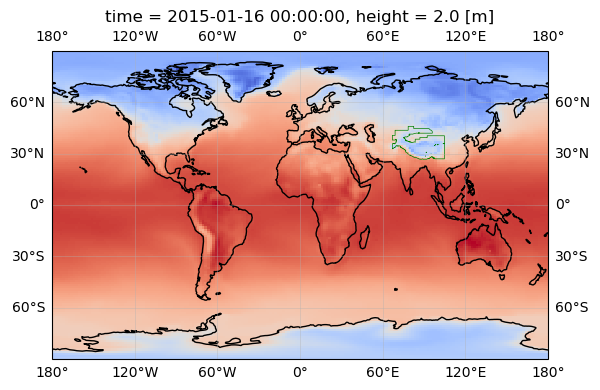

In [24]:
### show the global data
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': proj})
ax.add_feature(cfeat.COASTLINE)  ## 
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
cmip6_xds['tas'][0].plot(ax=ax,add_colorbar=False, cmap='coolwarm')
hma_gdf.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=0.5)


In [ ]:
## Clip the CMIP6 data to the HMA region  
cmip6_hma_xds = cmip6_clip(cmip6_xds=cmip6_xds, gdf=hma_gdf)


<GeoAxes: title={'center': 'time = 2015-01-16 00:00:00, height = 2.0 [m], s...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

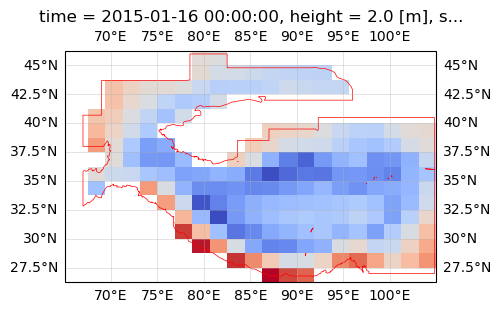

In [26]:
fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': proj})
ax.add_feature(cfeat.COASTLINE) 
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
cmip6_hma_xds['tas'][0].plot(ax=ax, add_colorbar=False, cmap='coolwarm')
hma_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)


In [ ]:
### (1) clip cmip6 data to HMA region
### (2) aggregate the data to spatial and temporal averages
for path in path_cmip6_nc:
    cmip6_xds = xr.open_dataset(path)
    if 'latitude' in cmip6_xds.coords:
        cmip6_xds = cmip6_xds.rename({'latitude': 'lat', 'longitude': 'lon'})
    if 'height' in cmip6_xds.coords:
        cmip6_xds = cmip6_xds.drop_vars('height')
    cmip6_hma_xds = cmip6_clip(cmip6_xds=cmip6_xds, gdf=hma_gdf)
    hma_tas_xda = cmip6_hma_xds['tas']
    cmip6_exp, cmip6_mod = cmip6_xds.attrs['experiment_id'], cmip6_xds.attrs['source_id']
    try:
        hma_tas_sa_ta_xda = geog_agg(xda=hma_tas_xda, exp=cmip6_exp, mod=cmip6_mod)
        path_save = f'{DATADIR}/{cmip6_exp}/cmip6_agg_{cmip6_exp}_{cmip6_mod}_{str(hma_tas_sa_ta_xda.year[0].values)}_{str(hma_tas_sa_ta_xda.year[-1].values)}.nc'
        if os.path.exists(path_save): os.remove(path_save)      ## remove existing file
        hma_tas_sa_ta_xda.to_netcdf(path=path_save)
    except: print(f'{path} failed')
